In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dask.distributed import Client
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from common.preprocessing import CropDataProcessor

import time

import pickle

In [3]:
client = Client(processes=False)

In [4]:
train_data = pd.read_csv("../data/Crop_Data__train.csv")

In [5]:
train_data.shape

(164550, 25)

In [6]:
data_preprocessor = CropDataProcessor(train_data, excluded_features=['State', 'District', 'Dew_Frost_Point', 'Year'])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
data_preprocessor.get_training_data()[0].dtypes

Warning 1: Features are not processed yet.
Warning 2: Distribution of Yield may not be normal.


Lat                         float64
Long                        float64
GW_depth_Min                float64
GW_depth_Max                float64
Wells_depth_0_to_2            int64
Wells_depth_2_to_5            int64
Wells_depth_5_to_10           int64
Wells_depth_10_to_20        float64
Wells_depth_20_to_40        float64
Wells_depth_40_and_above    float64
Precipitation               float64
Solar_Radiation             float64
Surface_Pressure            float64
Humidity                    float64
Temp_Max                    float64
Temp_Min                    float64
Wind_Speed                  float64
Season                       object
Crop                         object
dtype: object

In [8]:
data_preprocessor.process_to_train()

Clustered Lat-Long to Geo Region.
Encoded Crop using WoE.
Transforming numerical features.
Transforming categorical features.


In [9]:
X, y = data_preprocessor.get_training_data()
X.shape, y.shape

((164550, 28), (164550,))

In [10]:
# print(data_preprocessor.process_to_predict(train_data.loc[100:105].drop(['Area', 'Production'], axis=1)).shape)
# data_preprocessor.process_to_predict(train_data.loc[100:105].drop(['Area', 'Production'], axis=1))[:10]

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

In [25]:
X_train.shape, X_val.shape

((131640, 28), (32910, 28))

In [16]:
start_time = time.time()

reg = RandomForestRegressor(n_estimators=40,
                            min_samples_split=2,
                            min_samples_leaf=2,
                            n_jobs=-1,
                            random_state=101)

with joblib.parallel_backend('dask'):
    reg.fit(X_train, y_train)
    
print(f"Finished in {time.time() - start_time} secs")

Finished in 10.303147792816162 secs


In [17]:
reg.score(X_train, y_train)

0.9735075151688256

In [18]:
reg.score(X_val, y_val)

0.8960729257744161

# Hyper-parameters search for RF

## RandomizedSearchCV

### Iter 1

In [10]:
param_space = {
    "n_estimators": np.arange(10, 101, 10),
    "max_depth": [25, 50, 75, 100],
    "min_samples_split": np.arange(2, 15, 2),
    "min_samples_leaf": np.arange(2, 11, 2)
}

In [11]:
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(), 
    param_distributions=param_space,
    cv=5,
    return_train_score=True,
    n_iter=100,
    n_jobs=-1,
    verbose=5)

In [12]:
with joblib.parallel_backend('dask'):
    random_search.fit(X, y)
    
# with open('random_search_1', 'wb') as f:
#     pickle.dump(random_search, f)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 4/5] END max_depth=75, min_samples_leaf=6, min_samples_split=10, n_estimators=20; total time=  29.5s
[CV 3/5] END max_depth=75, min_samples_leaf=6, min_samples_split=10, n_estimators=20; total time=  29.9s
[CV 2/5] END max_depth=75, min_samples_leaf=6, min_samples_split=10, n_estimators=20; total time=  36.1s
[CV 4/5] END max_depth=75, min_samples_leaf=2, min_samples_split=14, n_estimators=20; total time= 1.0min
[CV 3/5] END max_depth=75, min_samples_leaf=2, min_samples_split=14, n_estimators=20; total time= 1.1min
[CV 1/5] END max_depth=75, min_samples_leaf=2, min_samples_split=14, n_estimators=20; total time= 1.2min
[CV 2/5] END max_depth=75, min_samples_leaf=2, min_samples_split=14, n_estimators=20; total time= 1.2min
[CV 1/5] END max_depth=75, min_samples_leaf=6, min_samples_split=10, n_estimators=20; total time=  12.1s
[CV 5/5] END max_depth=75, min_samples_leaf=2, min_samples_split=14, n_estimators=20; total time=

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f7c98f65a58>>, <Task finished coro=<Worker.heartbeat() done, defined at /usr/local/lib/python3.6/dist-packages/distributed/worker.py:936> exception=RuntimeError('dictionary changed size during iteration',)>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 767, in _discard_future_result
    future.result()
  File "/usr/local/lib/python3.6/dist-packages/distributed/worker.py", line 949, in heartbeat
    for key in self.active_threads.values()
  File "/usr/local/lib/python3.6/dist-packages/distributed/worker.py", line 947, in <dictcomp>
    executing={
RuntimeError: dictionary changed size during iteration


[CV 1/5] END max_depth=100, min_samples_leaf=2, min_samples_split=6, n_estimators=60; total time= 4.9min
[CV 2/5] END max_depth=100, min_samples_leaf=2, min_samples_split=6, n_estimators=60; total time= 4.9min
[CV 5/5] END max_depth=50, min_samples_leaf=2, min_samples_split=4, n_estimators=20; total time=  10.9s
[CV 3/5] END max_depth=100, min_samples_leaf=2, min_samples_split=6, n_estimators=60; total time= 5.0min
[CV 4/5] END max_depth=100, min_samples_leaf=2, min_samples_split=6, n_estimators=60; total time= 4.9min
[CV 5/5] END max_depth=100, min_samples_leaf=2, min_samples_split=6, n_estimators=60; total time= 5.2min
[CV 1/5] END max_depth=75, min_samples_leaf=10, min_samples_split=6, n_estimators=50; total time= 4.8min
[CV 1/5] END max_depth=75, min_samples_leaf=6, min_samples_split=8, n_estimators=80; total time= 7.1min
[CV 2/5] END max_depth=75, min_samples_leaf=6, min_samples_split=8, n_estimators=80; total time= 7.0min
[CV 3/5] END max_depth=75, min_samples_leaf=6, min_samples

In [19]:
with open('random_search_1', 'rb') as f:
    random_search = pickle.load(f)

In [20]:
random_search.best_params_

{'n_estimators': 80,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 50}

In [21]:
random_search.best_score_

0.8967213813597409

Text(0, 0.5, 'Test Score')

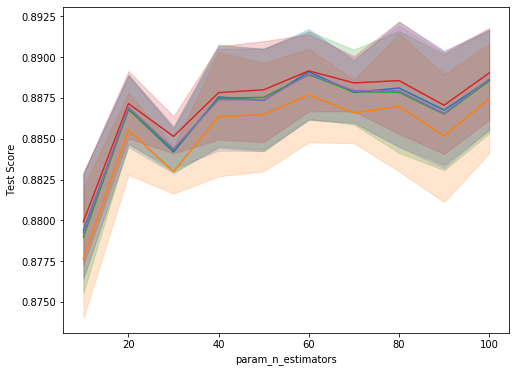

In [22]:
rs_cv_results_1 = pd.DataFrame(random_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='split0_test_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split1_test_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split2_test_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split3_test_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split4_test_score', data=rs_cv_results_1)
plt.ylabel('Test Score')

Text(0, 0.5, 'Score')

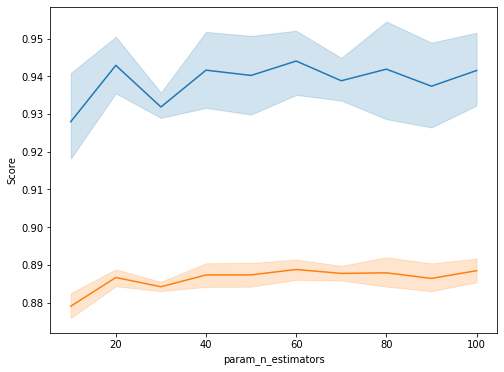

In [17]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=rs_cv_results_1)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

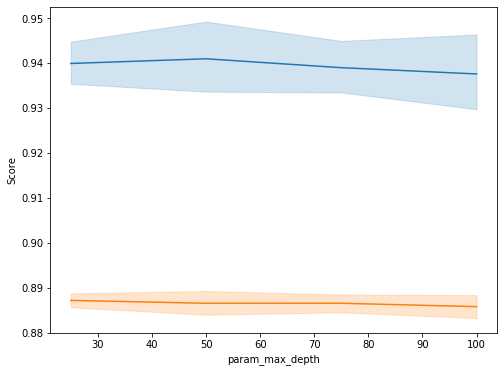

In [18]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=rs_cv_results_1)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=rs_cv_results_1)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

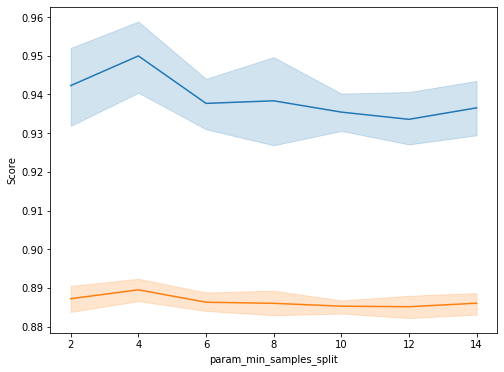

In [19]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_min_samples_split', y='mean_train_score', data=rs_cv_results_1)
sns.lineplot(x='param_min_samples_split', y='mean_test_score', data=rs_cv_results_1)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

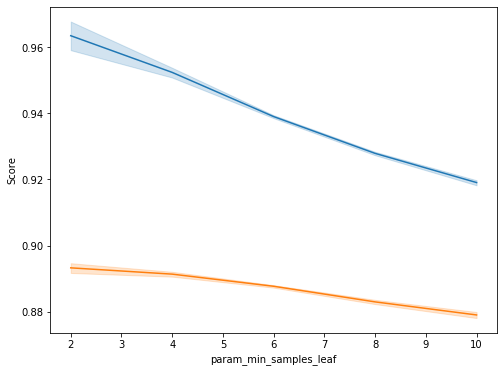

In [20]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_min_samples_leaf', y='mean_train_score', data=rs_cv_results_1)
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_cv_results_1)
plt.ylabel('Score')

In [21]:
rs_cv_results_1.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_depth', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

### Iter 2

In [ ]:
param_space_2 = {
    "n_estimators": np.arange(80, 151, 10),
    "max_depth": np.arange(80, 151, 10),
    "min_samples_split": [4],
    "min_samples_leaf": [2]
}

random_search_2 = RandomizedSearchCV(
    estimator=RandomForestRegressor(), 
    param_distributions=param_space_2,
    cv=5, 
    return_train_score=True,
    n_iter=50,
    verbose=5,
    n_jobs=-1
)

# with joblib.parallel_backend('dask'):
random_search_2.fit(X, y)

# with open('random_search_2', 'wb') as f:
#     pickle.dump(random_search_2, f)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [11]:
with open('random_search_2', 'rb') as f:
    random_search_2 = pickle.load(f)

In [12]:
random_search_2.best_params_

{'n_estimators': 130,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 150}

In [13]:
random_search_2.best_score_

0.8973615017891386

In [14]:
pd.DataFrame(random_search_2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,523.480097,3.402228,4.315821,0.138365,140,4,2,130,"{'n_estimators': 140, 'min_samples_split': 4, ...",0.897167,...,0.897145,0.000212,18,0.974457,0.974679,0.974643,0.974846,0.974797,0.974685,0.000136
1,522.352167,5.025176,4.350256,0.252730,140,4,2,80,"{'n_estimators': 140, 'min_samples_split': 4, ...",0.897987,...,0.897216,0.000420,7,0.974444,0.974479,0.974625,0.974978,0.974737,0.974652,0.000194
2,300.549514,3.559554,2.131804,0.147520,80,4,2,150,"{'n_estimators': 80, 'min_samples_split': 4, '...",0.897310,...,0.896707,0.000422,42,0.974191,0.974107,0.974259,0.974568,0.974523,0.974329,0.000183
3,568.345935,1.282841,4.436023,0.174393,150,4,2,140,"{'n_estimators': 150, 'min_samples_split': 4, ...",0.897292,...,0.897164,0.000172,14,0.974425,0.974579,0.974616,0.974911,0.974775,0.974661,0.000167
4,415.090421,1.318287,2.932201,0.144522,110,4,2,120,"{'n_estimators': 110, 'min_samples_split': 4, ...",0.897105,...,0.896772,0.000182,38,0.974302,0.974473,0.974443,0.974760,0.974556,0.974507,0.000151
5,519.041195,7.151702,3.813590,0.239828,140,4,2,110,"{'n_estimators': 140, 'min_samples_split': 4, ...",0.897463,...,0.897275,0.000343,4,0.974481,0.974558,0.974618,0.974927,0.974859,0.974689,0.000174
6,539.948338,7.587001,4.220986,0.800604,150,4,2,130,"{'n_estimators': 150, 'min_samples_split': 4, ...",0.897679,...,0.897202,0.000347,8,0.974538,0.974518,0.974596,0.974935,0.974820,0.974681,0.000166
7,354.146945,6.272108,2.821672,0.587115,100,4,2,140,"{'n_estimators': 100, 'min_samples_split': 4, ...",0.896895,...,0.896743,0.000173,39,0.974295,0.974356,0.974421,0.974718,0.974550,0.974468,0.000151
8,479.367826,3.731507,3.675241,0.044933,140,4,2,140,"{'n_estimators': 140, 'min_samples_split': 4, ...",0.897490,...,0.897347,0.000317,2,0.974360,0.974607,0.974664,0.974838,0.974745,0.974643,0.000161
9,270.870764,1.742148,1.974366,0.163808,80,4,2,90,"{'n_estimators': 80, 'min_samples_split': 4, '...",0.896506,...,0.896640,0.000278,44,0.974042,0.974296,0.974322,0.974427,0.974362,0.974290,0.000131


Text(0, 0.5, 'Test Score')

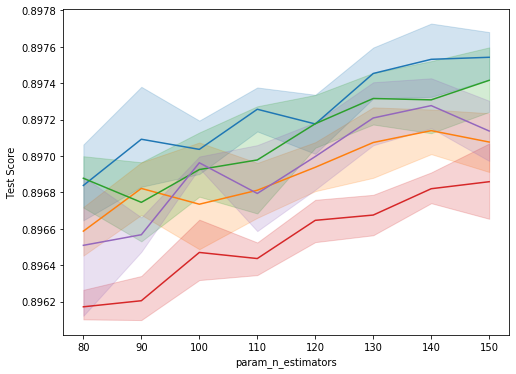

In [15]:
rs_cv_results_2 = pd.DataFrame(random_search_2.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='split0_test_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split1_test_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split2_test_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split3_test_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split4_test_score', data=rs_cv_results_2)
plt.ylabel('Test Score')

Text(0, 0.5, 'Score')

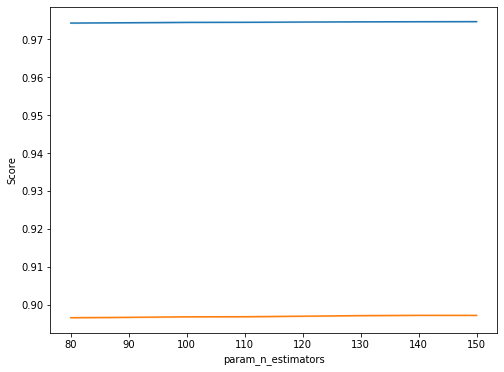

In [16]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=rs_cv_results_2)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

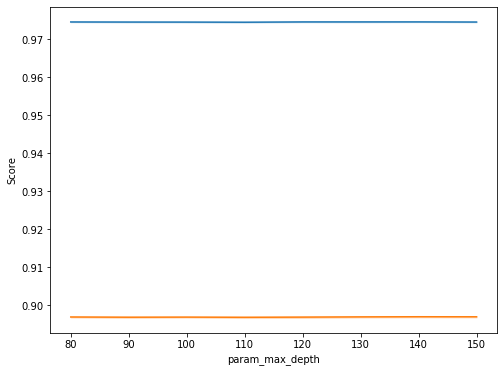

In [17]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=rs_cv_results_2)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=rs_cv_results_2)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

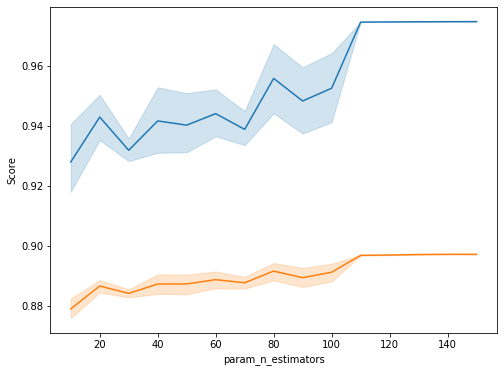

In [23]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=pd.concat([rs_cv_results_1, rs_cv_results_2]))
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=pd.concat([rs_cv_results_1, rs_cv_results_2]))
plt.ylabel('Score')

Text(0, 0.5, 'Score')

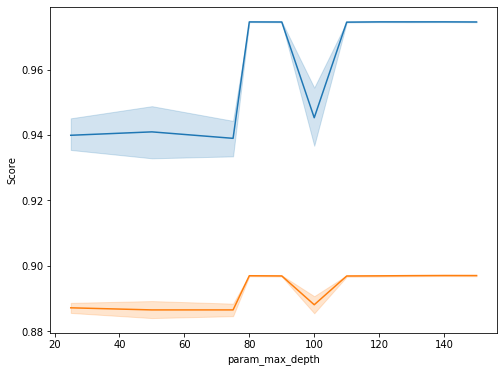

In [24]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=pd.concat([rs_cv_results_1, rs_cv_results_2]))
sns.lineplot(x='param_max_depth', y='mean_test_score', data=pd.concat([rs_cv_results_1, rs_cv_results_2]))
plt.ylabel('Score')

## GridSearchCV

### Iter 1

In [25]:
grid_param = {
    "n_estimators": np.arange(100, 151, 10),
    "max_depth": np.arange(80, 121, 10),
    "min_samples_split": [4],
    "min_samples_leaf": [2]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=101),
    param_grid=grid_param,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=10)

# with joblib.parallel_backend('dask'):
grid_search.fit(X, y)

# with open('grid_search_1', 'wb') as f:
#     pickle.dump(grid_search, f)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [10]:
with open('grid_search_1', 'rb') as f:
    grid_search = pickle.load(f)

In [11]:
grid_search.best_params_

{'max_depth': 80,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

In [12]:
grid_search.best_score_

0.8971432368321233

Text(0, 0.5, 'Test Score')

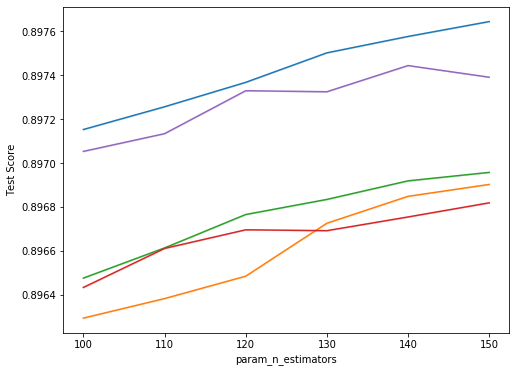

In [13]:
gs_cv_results_1 = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='split0_test_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split1_test_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split2_test_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split3_test_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split4_test_score', data=gs_cv_results_1)
plt.ylabel('Test Score')

Text(0, 0.5, 'Score')

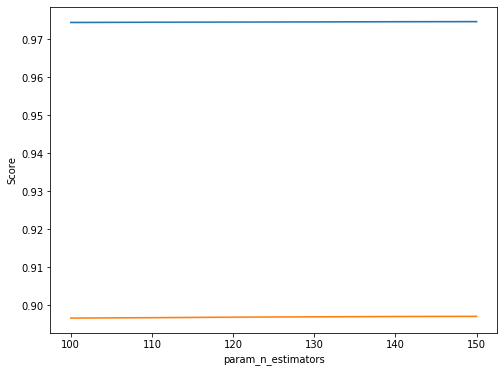

In [30]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=gs_cv_results_1)
plt.ylabel('Score')

In [31]:
gs_cv_results_1.mean_train_score.std()

7.925094781370236e-05

In [32]:
gs_cv_results_1.mean_test_score.std()

0.00016705779354103754

Text(0, 0.5, 'Score')

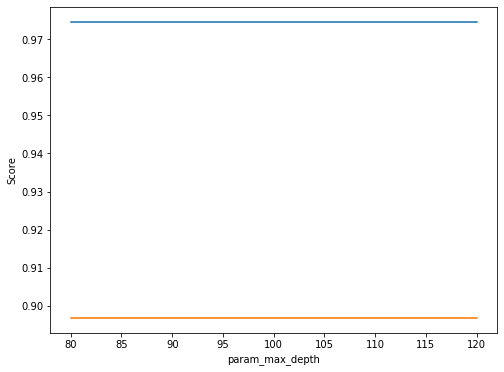

In [33]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=gs_cv_results_1)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=gs_cv_results_1)
plt.ylabel('Score')

### Iter 2

In [ ]:
grid_param_2 = {
    "n_estimators": np.arange(10, 101, 10),
    "max_depth": np.arange(10, 81, 10),
    "min_samples_split": [4],
    "min_samples_leaf": [2]
}

grid_search_2 = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=101),
    param_grid=grid_param_2,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=10)

# with joblib.parallel_backend('dask'):
grid_search_2.fit(X, y)

# with open('grid_search_2', 'wb') as f:
#     pickle.dump(grid_search_2, f)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [14]:
with open('grid_search_2', 'rb') as f:
    grid_search_2 = pickle.load(f)

In [15]:
grid_search_2.best_params_

{'max_depth': 40,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

In [16]:
grid_search_2.best_score_

0.8967191492598052

Text(0, 0.5, 'Test Score')

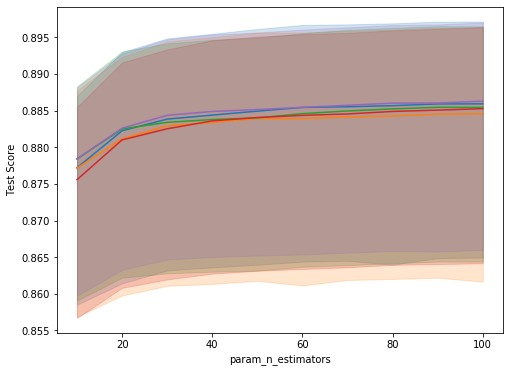

In [17]:
gs_cv_results_2 = pd.DataFrame(grid_search_2.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='split0_test_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split1_test_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split2_test_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split3_test_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split4_test_score', data=gs_cv_results_2)
plt.ylabel('Test Score')

Text(0, 0.5, 'Score')

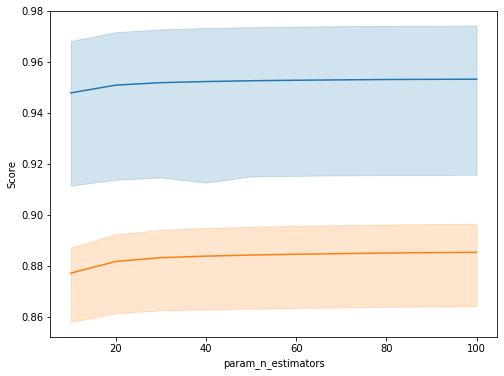

In [18]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=gs_cv_results_2)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

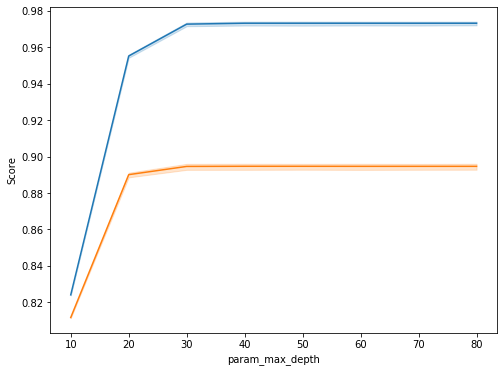

In [19]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=gs_cv_results_2)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=gs_cv_results_2)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

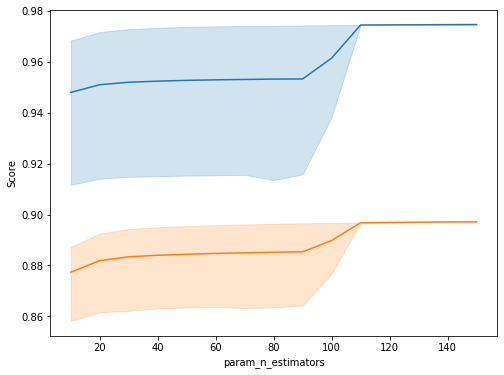

In [20]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=pd.concat([gs_cv_results_2, gs_cv_results_1]))
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=pd.concat([gs_cv_results_2, gs_cv_results_1]))
plt.ylabel('Score')

Text(0, 0.5, 'Score')

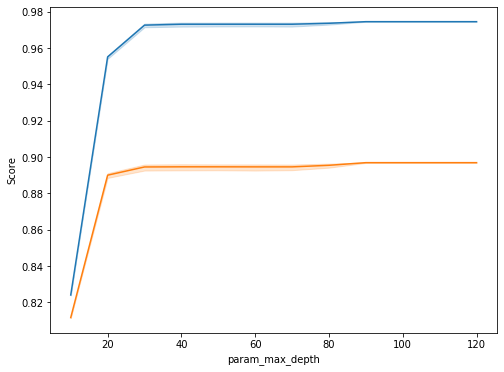

In [21]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=pd.concat([gs_cv_results_2, gs_cv_results_1]))
sns.lineplot(x='param_max_depth', y='mean_test_score', data=pd.concat([gs_cv_results_2, gs_cv_results_1]))
plt.ylabel('Score')

# Model based on hyper-parameters search

Based on above results we get following as best possible hyperparameters for RandomForestRegressor:

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 110}

In [26]:
reg = RandomForestRegressor(n_estimators=110,
                            max_depth=20,
                            min_samples_leaf=2,
                            min_samples_split=4,
                            n_jobs=-1,
                            random_state=101)

In [27]:
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=110, n_jobs=-1, random_state=101)

In [28]:
print("Training score: ", reg.score(X_train, y_train))

Training score:  0.9564109059098229


In [29]:
print("Test score: ", reg.score(X_val, y_val))

Test score:  0.8917117741225009
